# Evaluation of Untrained Metrics through Correlation with Human Judgment: the Case of Translation





In this notebook, you will find the implementation of the experiments considered in the paper: *Evaluation of Untrained Metrics through Correlation with Human Judgment: the Case of Translation* by A. Lanson and A. Tordjman (2023).

We consider several metrics (see Table below), both string-based and embedding-based. For each metric, we derive correlations between the metric's score and human judgement scores given in the selected dataset. We use three correlation measures: Pearson’s coefficient measures linear correlation, while Spearman's and Kendall's coefficients compare the ranks of data. We also compare metric with these correlation measures. In the last section, we perform a significance test to check how trust-worthy the differences between our metric scores are.

## Table of contents

1. Data loading
2. String-based metrics
3. Embedding-based metrics
4. Correlation between metric prediction and human judgement
5. Correlation among metrics
6. Significance testing


### Considered metrics:

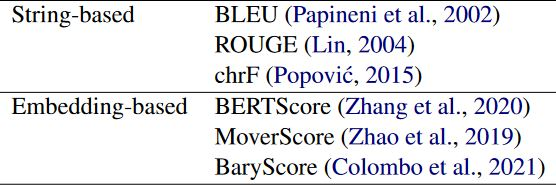

In [ ]:
import pandas as pd
import numpy as np 
import scipy.stats
import matplotlib.pyplot as plt

## 1. Data loading

We use the WMT16 dataset (Bojar et al., 2016), composed of around 500 sentences per language. We focus on the de-en pair, that is translation from German to English. The data is available at https://www.statmt.org/wmt16/metrics-task/.

The dataset contains: 

- the source English sentence
- the Machine Translation output (blind, no identification of the actual system that produced it)
- the reference translation
- the human score (a real number between -1.9 and 1.3)
- sBLEU (a real number between 0 and 1)

We are interested by both English sentences and the human score.


In [ ]:
# Get the dataset
!wget https://www.statmt.org/wmt16/metrics-task/wmt2016-seg-metric-dev-5lps.tar.gz

# Unzip the dataset
!tar -xvzf wmt2016-seg-metric-dev-5lps.tar.gz

# Move the dataset to the data/ directory. If the data/ directory already exists, overwrite it.
!rm -rf data/wmt2016-seg-metric-dev-5lps
!mv wmt2016-seg-metric-dev-5lps data/

# Remove the compressed file
!rm wmt2016-seg-metric-dev-5lps.tar.gz

In [ ]:
human_score = []
references = []
candidates = [] 

# Get the human score, the candidate and reference sentences for the de-en pair
with open(f"data/de-en/newstest2015.human.de-en") as f:
  for line in f.readlines():
    human_score.append(line.strip())
with open(f"data/de-en/newstest2015.mt-system.de-en") as f:
  for line in f.readlines():
    candidates.append(line.strip())
with open(f"data/de-en/newstest2015.reference.de-en") as f:
  for line in f.readlines():
    references.append(line.strip())

# Convert the human_score list to a list of floats
human_score = list(np.float_(human_score))

In [ ]:
# example of two sentences and the associated human score
index = 10
print(f"reference: {references[index]}\ncandidate: {candidates[index]}\nassociated human score {human_score[index]}")

reference: May I suggest you read fewer novels.
candidate: I suggest that you read a few novels.
associated human score -0.642182387542613


## 2. String-based metrics

We first consider some common metrics: BLEU (Bilingual Evaluation Understudy), ROUGE (Recall-Oriented Understudy for Gisting Evaluation) and chrF (character n-gram F-score), that are string-base metrics: they evaluate the textual representation of the inputs.

In [ ]:
! pip install evaluate

In [ ]:
import evaluate

In [ ]:
from evaluate import load

### BLEU

https://github.com/mjpost/sacrebleu

In [ ]:
! pip install sacrebleu

In [ ]:
# set configuration
sacrebleu = evaluate.load("sacrebleu")
bleu = sacrebleu.compute(predictions=candidates, references=references)

In [ ]:
# list of scores for each pair of sentences
bleu_list=[]
for i in range(len(candidates)):
  bleu_list.append(sacrebleu.compute(predictions=[candidates[i]], references=[references[i]])['score'])

In [ ]:
# Correlation coefficients between bleu scores and human similarity scores (coef, pval)
bleu_r = scipy.stats.pearsonr(bleu_list, human_score)    # Pearson's r
bleu_rho = scipy.stats.spearmanr(bleu_list, human_score)   # Spearman's rho
bleu_tau = scipy.stats.kendalltau(bleu_list, human_score)  # Kendall's tau

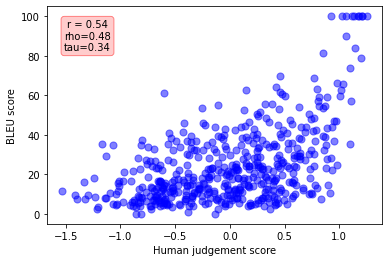

In [ ]:
# Vizualisation of correlations (is there a pattern?)
plt.scatter(human_score, bleu_list, c='blue', alpha = 0.5, s=50)
plt.xlabel("Human judgement score")
plt.ylabel("BLEU score")
plt.text(-1.3, 90, "r = {}\nrho={}\ntau={}".format(round(bleu_r[0],2), round(bleu_rho[0],2), round(bleu_tau[0],2)), 
         size=10, ha="center", va="center", 
            bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
#plt.savefig("Bleu score vs human judgement")
plt.show()

### ROUGE

 https://github.com/google-research/google-research/tree/master/rouge

In [ ]:
! pip install rouge_score

In [ ]:
# set configuration
rouge = evaluate.load('rouge')
rouge_results = rouge.compute(predictions=candidates, references=references)

In [ ]:
# list of scores for each pair of sentences
rouge_list=[]
for i in range(len(candidates)):
  rouge_list.append(rouge.compute(predictions=[candidates[i]], references=[references[i]])['rouge1'])

In [ ]:
# Correlation coefficients between rouge scores and human similarity scores (coef, pval)
rouge_r = scipy.stats.pearsonr(rouge_list, human_score)    # Pearson's r
rouge_rho = scipy.stats.spearmanr(rouge_list, human_score)   # Spearman's rho
rouge_tau = scipy.stats.kendalltau(rouge_list, human_score)  # Kendall's tau

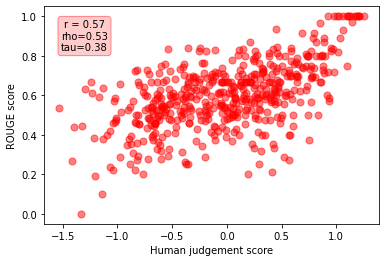

In [ ]:
# Vizualisation of correlations (is there a pattern?)
plt.scatter(human_score, rouge_list, c='red', alpha = 0.5, s=50)
plt.xlabel("Human judgement score")
plt.ylabel("ROUGE score")

plt.text(-1.3, 0.9, "r = {}\nrho={}\ntau={}".format(round(rouge_r[0],2), round(rouge_rho[0],2), round(rouge_tau[0],2)), 
         size=10, ha="center", va="center", 
            bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))

#plt.savefig("Rouge score vs human judgement")

plt.show()

### chrFScore

https://github.com/mjpost/sacreBLEU#chrf--chrf

In [ ]:
chrf = evaluate.load("chrf")
chrf_results = chrf.compute(predictions=candidates, references=references)

In [ ]:
# list of scores for each pair of sentences
chrf_list=[]
for i in range(len(candidates)):
  chrf_list.append(chrf.compute(predictions=[candidates[i]], references=[references[i]])['score'])

In [ ]:
# Correlation coefficients between rouge scores and human similarity scores (coef, pval)
chrf_r = scipy.stats.pearsonr(chrf_list, human_score)    # Pearson's r
chrf_rho = scipy.stats.spearmanr(chrf_list, human_score)   # Spearman's rho
chrf_tau = scipy.stats.kendalltau(chrf_list, human_score)  # Kendall's tau

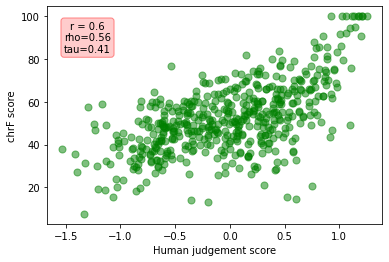

In [ ]:
# Vizualisation of correlations
plt.scatter(human_score, chrf_list, c='green', alpha = 0.5, s=50)
plt.xlabel("Human judgement score")
plt.ylabel("chrF score")

plt.text(-1.3, 90, "r = {}\nrho={}\ntau={}".format(round(chrf_r[0],2), round(chrf_rho[0],2), round(chrf_tau[0],2)), 
         size=10, ha="center", va="center", 
            bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))

#plt.savefig("chrF score vs human judgement")

plt.show()

## 3. Embedding-based metrics

We now consider more complex metrics,  that rely on contextualized embeddings: BERTScore, MoverScore, and BaryScore.

In [ ]:
! pip install transformers

In [ ]:
import transformers

In [ ]:
model_type="distilbert-base-uncased"

### BERTScore

https://github.com/Tiiiger/bert_score

In [ ]:
! pip install "git+https://github.com/Tiiiger/bert_score"

In [ ]:
from bert_score import score

In [ ]:
Precision, Recall, F1 = score(candidates, references, model_type=model_type, lang='en', verbose=True)

In [ ]:
# list of scores for each pair of sentences
bert_list=list(np.float_(F1))

In [ ]:
# Correlation coefficients between bert scores and human similarity scores (coef, pval)
bert_r = scipy.stats.pearsonr(bert_list, human_score)    # Pearson's r
bert_rho = scipy.stats.spearmanr(bert_list, human_score)   # Spearman's rho
bert_tau = scipy.stats.kendalltau(bert_list, human_score)  # Kendall's tau

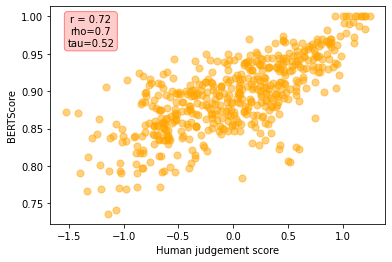

In [ ]:
# Vizualisation of correlations
plt.scatter(human_score, bert_list, c='orange', alpha = 0.5, s=50)
plt.xlabel("Human judgement score")
plt.ylabel("BERTScore")

plt.text(-1.3, 0.98, "r = {}\nrho={}\ntau={}".format(round(bert_r[0],2), round(bert_rho[0],2), round(bert_tau[0],2)), 
         size=10, ha="center", va="center", 
            bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))

#plt.savefig("BERT score vs human judgement")

plt.show()

### MoverScore

https://github.com/AIPHES/emnlp19-moverscore

In [ ]:
! pip install "git+https://github.com/AIPHES/emnlp19-moverscore"
! pip install pyemd

In [ ]:
from moverscore_v2 import get_idf_dict, word_mover_score # moverscore_v2 uses DistilBERT by default
from collections import defaultdict

idf_dict_hyp = get_idf_dict(candidates)
idf_dict_ref = get_idf_dict(references)

moverscores = word_mover_score(references, candidates, idf_dict_ref, idf_dict_hyp) 

In [ ]:
# list of scores for each pair of sentences
mover_list = moverscores

In [ ]:
# Correlation coefficients between moverscores and human similarity scores (coef, pval)
mover_r = scipy.stats.pearsonr(mover_list, human_score)    # Pearson's r
mover_rho = scipy.stats.spearmanr(mover_list, human_score)   # Spearman's rho
mover_tau = scipy.stats.kendalltau(mover_list, human_score)  # Kendall's tau

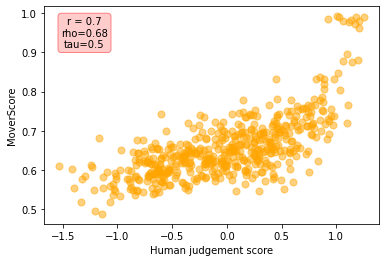

In [ ]:
# Vizualisation of correlations
plt.scatter(human_score, mover_list, c='orange', alpha = 0.5, s=50)
plt.xlabel("Human judgement score")
plt.ylabel("MoverScore")

plt.text(-1.3, 0.95, "r = {}\nrho={}\ntau={}".format(round(mover_r[0],2), round(mover_rho[0],2), round(mover_tau[0],2)), 
         size=10, ha="center", va="center", 
            bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))

#plt.savefig("MoverScore vs human judgement")

plt.show()

### BaryScore

https://github.com/PierreColombo/nlg_eval_via_simi_measures.git

In [ ]:
! pip install "git+https://github.com/PierreColombo/nlg_eval_via_simi_measures.git"

In [ ]:
import nlg_eval_via_simi_measures
from nlg_eval_via_simi_measures import BaryScoreMetric

In [ ]:
# set configuration
baryscore = BaryScoreMetric(model_name = model_type, use_idfs=False)

baryscore.prepare_idfs(references, candidates)
bary = baryscore.evaluate_batch(references, candidates)

In [ ]:
# list of scores for each pair of sentences
bary_list = bary['baryscore_W']

In [ ]:
# Correlation coefficients between baryscores and human similarity scores (coef, pval)
bary_r = scipy.stats.pearsonr(bary_list, human_score)    # Pearson's r
bary_rho = scipy.stats.spearmanr(bary_list, human_score)   # Spearman's rho
bary_tau = scipy.stats.kendalltau(bary_list, human_score)  # Kendall's tau

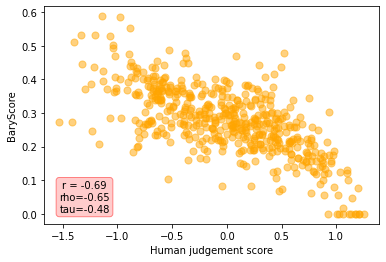

In [ ]:
# Vizualisation of correlations
plt.scatter(human_score, bary_list, c='orange', alpha = 0.5, s=50)
plt.xlabel("Human judgement score")
plt.ylabel("BaryScore")

plt.text(-1.3, 0.05, "r = {}\nrho={}\ntau={}".format(round(bary_r[0],2), round(bary_rho[0],2), round(bary_tau[0],2)), 
         size=10, ha="center", va="center", 
            bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))

#plt.savefig("Bary score vs human judgement")

plt.show()

## 4. Correlation between metric prediction and human judgement

This section aims at summarizing the results obtained earlier.



In [ ]:
# Let's gather the results of correlation's calculations between metrics' prediction and human judgement in a dataframe
# We consider absolute coefficients, rounded to two digits

metrics_name = ['BLEU', 'ROUGE', 'CHRF', 'BERTS', 'MoverS', 'BaryS']

# correlation coefficients
r_list = np.absolute(np.round(np.array([bleu_r[0], rouge_r[0], chrf_r[0], bert_r[0], mover_r[0], bary_r[0]]), 2))
rho_list = np.absolute(np.round(np.array([bleu_rho[0], rouge_rho[0], chrf_rho[0], bert_rho[0], mover_rho[0], bary_rho[0]]), 2))
tau_list = np.absolute(np.round(np.array([bleu_tau[0], rouge_tau[0], chrf_tau[0], bert_tau[0], mover_tau[0], bary_tau[0]]), 2))

# pvalues
r_pval = np.round(np.array([bleu_r[1], rouge_r[1], chrf_r[1], bert_r[1], mover_r[1], bary_r[1]]), 4)
rho_pval = np.round(np.array([bleu_rho[1], rouge_rho[1], chrf_rho[1], bert_rho[1], mover_rho[1], bary_rho[1]]), 4)
tau_pval = np.round(np.array([bleu_tau[1], rouge_tau[1], chrf_tau[1], bert_tau[1], mover_tau[1], bary_tau[1]]), 4)

# create dataframe
results_df = pd.DataFrame({'Metric': metrics_name, 
                           'r': r_list, 'r_pval': r_pval, 
                           'rho': rho_list, 'rho_pval': rho_pval, 
                           'tau': tau_list, 'tau_pval': tau_pval})
results_df

,Metric,r,r_pval,rho,rho_pval,tau,tau_pval
0,BLEU,0.54,0.0,0.48,0.0,0.34,0.0
1,ROUGE,0.57,0.0,0.53,0.0,0.38,0.0
2,CHRF,0.60,0.0,0.56,0.0,0.41,0.0
3,BERTS,0.72,0.0,0.70,0.0,0.52,0.0
4,MoverS,0.70,0.0,0.68,0.0,0.50,0.0
5,BaryS,0.69,0.0,0.65,0.0,0.48,0.0


## 5. Correlation among metrics

In [ ]:
metrics_list = np.array([bleu_list, rouge_list, chrf_list, bert_list, mover_list, bary_list])

In [ ]:
metrics_df = pd.DataFrame({'BLEU': bleu_list, 
                           'ROUGE': rouge_list, 'chrF': chrf_list, 
                           'BERT': bert_list, 'MoverS': mover_list, 
                           'BaryS': bary_list})
metrics_df.head(3)

,BLEU,ROUGE,chrF,BERT,MoverS,BaryS
0,53.059037,0.937500,83.943449,0.973993,0.832012,0.106288
1,42.501126,0.666667,65.835636,0.944329,0.696805,0.195637
2,21.679089,0.541667,38.541438,0.817039,0.568347,0.441143


In [ ]:
# absolute correlation matrix
pearson_corr_matrix = np.absolute(metrics_df.corr(method='pearson').round(decimals=2))
spearman_corr_matrix = np.absolute(metrics_df.corr(method='spearman').round(decimals=2))
kendall_corr_matrix = np.absolute(metrics_df.corr(method='kendall').round(decimals=2))

Visualization

In [ ]:
import seaborn as sns

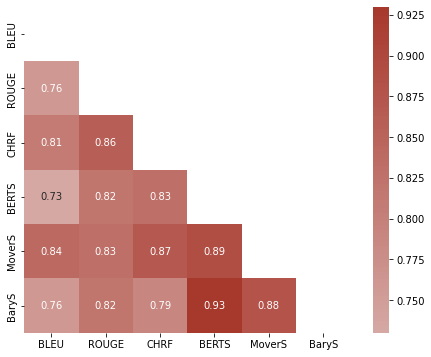

In [ ]:
# Pearson's heatmap
mask = np.triu(np.ones_like(pearson_corr_matrix, dtype=bool))

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr_matrix, mask=mask, center=0.6, annot=True,
            fmt='.2f', square=True, cmap=cmap, xticklabels=metrics_name, yticklabels=metrics_name)

#plt.savefig("pearsonheatmap")

plt.show()

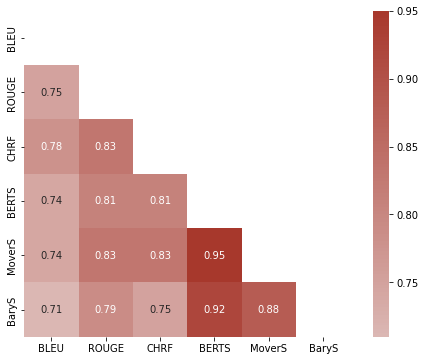

In [ ]:
# Spearman's heatmap
mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool))

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr_matrix, mask=mask, center=0.6, annot=True,
            fmt='.2f', square=True, cmap=cmap, xticklabels=metrics_name, yticklabels=metrics_name)

#plt.savefig("spearmanheatmap")

plt.show()

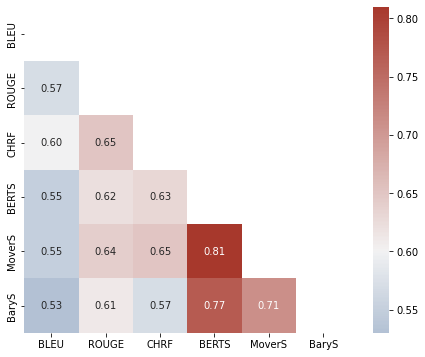

In [ ]:
# Kendall's heatmap
mask = np.triu(np.ones_like(kendall_corr_matrix, dtype=bool))

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(kendall_corr_matrix, mask=mask, center=0.6, annot=True,
            fmt='.2f', square=True, cmap=cmap, xticklabels=metrics_name, yticklabels=metrics_name)

#plt.savefig("kendallheatmap")

plt.show()

## 6. Significance testing

To check how trust-worthy the differences between our metric scores are, we perform statistical significance testing using Williams' test as considered observations are correlated.

https://github.com/inmoonlight/nlp-williams

In [ ]:
! git clone https://github.com/inmoonlight/nlp-williams.git nlp_williams

Cloning into 'nlp_williams'...
remote: Enumerating objects: 9, done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (9/9), 9.51 KiB | 648.00 KiB/s, done.


In [ ]:
from nlp_williams.williams import williams_test

In [ ]:
import itertools

In [ ]:
# create all combinations of coefficients pairs
r_pairs=list(itertools.combinations(r_list, 2))
r_pairs = [list(element) for element in r_pairs]

# sort the pairs such that the highest number is the first of each pair (necessary for Williams test)
r_pairs = [sorted(r_pairs[i],reverse=True) for i in range(len(r_pairs))]

In [ ]:
# create all combinations of metrics list pairs
metrics_pairs=list(itertools.combinations(metrics_list, 2))

In [ ]:
# Pearson's r
r_among_metrics = np.absolute(np.round(np.array([scipy.stats.pearsonr(u, v)[0] for u,v in metrics_pairs]), 2))

In [ ]:
n=500

In [ ]:
# derive pvalues of Williams test
williams_list = np.round([williams_test(r_pairs[i][0], r_pairs[i][1], r_among_metrics[i], n)[1] for i in range(len(r_pairs))], 2)

Visualisation

In [ ]:
# Create a matrix for pvalues
williams_matrix = np.zeros([6,6], dtype=np.double)
williams_matrix[np.triu_indices(6, k=1)] = williams_list
williams_matrix = williams_matrix + williams_matrix.T
williams_matrix[np.diag_indices(6)] = 0

In [ ]:
williams_matrix

array([[0.  , 0.12, 0.  , 0.  , 0.  , 0.  ],
       [0.12, 0.  , 0.06, 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.08, 0.01],
       [0.  , 0.  , 0.  , 0.08, 0.  , 0.26],
       [0.  , 0.  , 0.  , 0.01, 0.26, 0.  ]])

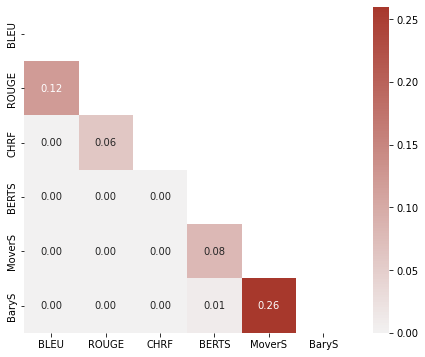

In [ ]:
# Williams pvalues heatmap
mask = np.triu(np.ones_like(williams_matrix, dtype=bool))

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(williams_matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap, xticklabels=metrics_name, yticklabels=metrics_name)

#plt.savefig("williamsheatmap")

plt.show()